## ResNet50 first trained on 224X224 resolution, then 512X512

Finally, after convincing myself not to be stingy on using resources, I achieved 88.36% accuracy without Test time augmentation (TTA) and 89.63% with TTA.

In [2]:
# imports
import os
import random
import shutil

from pathlib import Path
import urllib

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = Path('data/food-101')
path_meta = path /'meta'
path_images = path/'images'

In [4]:
path_meta


PosixPath('data/food-101/meta')

In [5]:
def build_data_frame(path_name, file_name, img_format = 'jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input paramters:
    path_name : path 
    file_name : file name, string
    img_format : default format is jpg
    
    return dataframe
    """
    path_file = path_name/file_name
    file_df = pd.read_csv(path_file,delimiter='/', header=None, names=['label', 'image_file'])
    file_df['image_file'] = file_df['label'].astype(str) + '/' + file_df['image_file'].astype(str) + '.'+img_format
    
    return file_df

In [6]:
train_df = build_data_frame(path_meta, 'train.txt')
test_df = build_data_frame(path_meta, 'test.txt')


In [7]:
train_df.head()

,label,image_file
0,apple_pie,apple_pie/1005649.jpg
1,apple_pie,apple_pie/1014775.jpg
2,apple_pie,apple_pie/1026328.jpg
3,apple_pie,apple_pie/1028787.jpg
4,apple_pie,apple_pie/1043283.jpg


In [8]:
test_df.head()

,label,image_file
0,apple_pie,apple_pie/1011328.jpg
1,apple_pie,apple_pie/101251.jpg
2,apple_pie,apple_pie/1034399.jpg
3,apple_pie,apple_pie/103801.jpg
4,apple_pie,apple_pie/1038694.jpg


### Image Augmentation

In [9]:
#batch size set to 64 for 224X224
bs = 64

In [27]:
# Decorator for crop tfm functions, it crops the images but if the target size is bigger than the size of the image (on either dimension), padding is applied to padding_mode
# and the position of the center is ignored on that dimension
Crop_pads = RandTransform(tfm=TfmCrop(crop_pad),\
                       kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, \
                       p=1.0, \
                       resolved={}, \
                       do_run=True, \
                       is_random=True)

# Decorator for flip_affine function, it flip image horizontally.
Affine_flip = RandTransform(tfm=TfmAffine(flip_affine),\
                            kwargs={}, \
                            p=0.5, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

# Decorator for symmetric_warp, which applies the four tilts at the same time, each with a strength given in the vector magnitude.
Coord_warp = RandTransform(tfm=TfmCoord(symmetric_warp), \
                           kwargs={'magnitude': (-0.2, 0.2)}, \
                           p=0.75, \
                           resolved={}, \
                           do_run=True, \
                           is_random=True)

#Decorator for rotate, which image by degrees
Affine_rotate = RandTransform(tfm=TfmAffine(rotate),\
                              kwargs={'degrees': (-20.0, 20.0)}, \
                              p=0.75, \
                              resolved={}, \
                              do_run=True, \
                              is_random=True)

#Decorator for zoom, which zoom image by scale. row_pct, col_pct select focal point of zoom
Affine_zoom = RandTransform(tfm=TfmAffine(zoom), \
                            kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, \
                            p=0.75, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

#Decorator for brightness, which adjusts the brightness of the image depending on the value of change. A change of 0 will transform the image to black
#and a change of 1 will transform the image to white, change=0.5 doesn't adjust the brightness.
Lighting_brightness = RandTransform(tfm=TfmLighting(brightness), \
                         kwargs={'change': (0.4, 0.6)}, \
                         p=0.75, \
                         resolved={}, \
                         do_run=True, \
                         is_random=True)

#Decorator of contrast, which apply scale to constrast of image, a scale of 0 will transform the image to grey, and a scale of 1 will transform the picture 
#to super_contrast. scale=1 doesn't adjust the contrast.
Lighting_contrast = RandTransform(tfm=TfmLighting(contrast),\
                                  kwargs={'scale': (0.8, 1.25)}, \
                                  p=0.75, \
                                  resolved={}, \
                                  do_run=True,\
                                  is_random=True)

#Decorator of crop_pad, this is applied to validation set.
Crops = RandTransform(tfm=TfmCrop(crop_pad), \
                      kwargs={}, \
                      p=1.0, \
                      resolved={},\
                      do_run=True, \
                      is_random=True)

# Training Set Random Augmentation
train_tfms = [Crop_pads,Affine_flip,Coord_warp,Affine_rotate,Affine_zoom,Lighting_brightness,Lighting_contrast]

# validation set Random Augmentation
valid_tfms = [Crops]

random_tfms = (train_tfms,valid_tfms)

In [28]:
train_data = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(random_tfms, size=224)\
                            .databunch(bs=bs)\
                            .normalize(imagenet_stats))


### Metrics

**Top-1 Accuracy** and **Top-5 Accuracy** are standard metrics for the image classification problems. I will use the these two metrics to compare with the SoTA results


In [30]:
top_5_accuracy = partial(top_k_accuracy, k=5)

learn = cnn_learner(train_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)

### Learning Rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


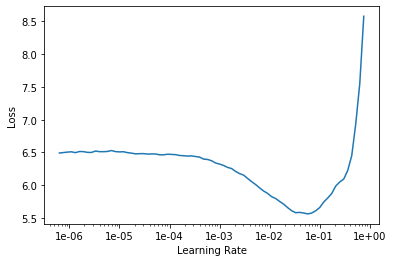

In [33]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.174354,1.718389,0.562706,0.818680,09:43
1,1.819407,1.492466,0.614059,0.850099,05:58
2,1.622179,1.335536,0.644554,0.876502,05:59
3,1.508441,1.231932,0.674521,0.888647,05:58
4,1.331491,1.129709,0.700198,0.900858,05:58
5,1.162864,1.038259,0.726931,0.911485,05:58
6,1.071995,0.988778,0.737030,0.917558,06:00
7,1.038572,0.980541,0.740462,0.917822,06:00


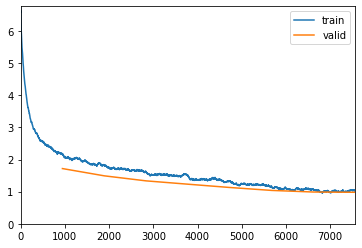

In [34]:
lr = 1e-2
learn.fit_one_cycle(8, slice(lr))
learn.save('food-101-ResNet50-v1')

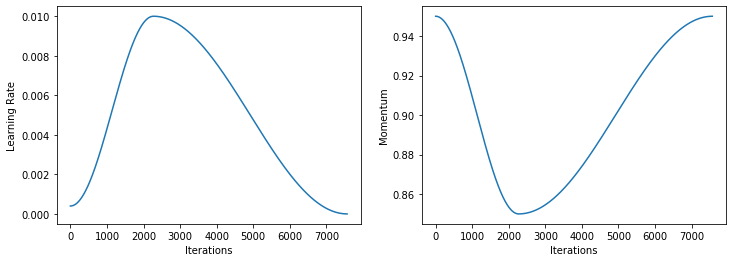

In [35]:
# the learning rate and momentum scheduling 
learn.recorder.plot_lr(show_moms=True)

### Unfreeze ResNet50 Model 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


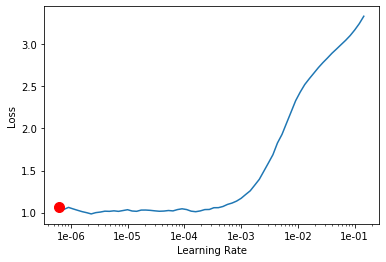

In [36]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.074485,0.986047,0.738878,0.917558,06:11
1,1.137731,1.041657,0.725215,0.911155,06:11
2,1.032148,0.949828,0.743630,0.922904,06:11
3,0.884649,0.892908,0.766337,0.926073,06:13
4,0.719440,0.819390,0.785743,0.936766,06:12
5,0.562762,0.774400,0.798944,0.941386,06:13
6,0.452810,0.754067,0.808581,0.944488,06:11
7,0.419335,0.747758,0.809769,0.943828,06:11


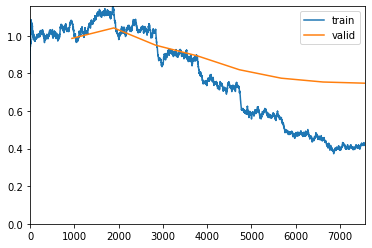

In [37]:
learn.fit_one_cycle(8, max_lr=slice(1e-5, 1e-3))
learn.save('food-101-ResNet50-unfreezed')

In [31]:
learn.load('food-101-ResNet50-unfreezed')

Learner(data=ImageDataBunch;

Train: LabelList (60600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: data/food-101/images;

Valid: LabelList (15150 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
hummus,scallops,peking_duck,chicken_quesadilla,baby_back_ribs
Path: data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchN

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.411698,0.773615,0.808317,0.942706,10:51
1,0.393553,0.781113,0.808779,0.943234,06:26
2,0.391972,0.785511,0.808845,0.943762,06:26
3,0.373096,0.785478,0.809571,0.943498,06:24


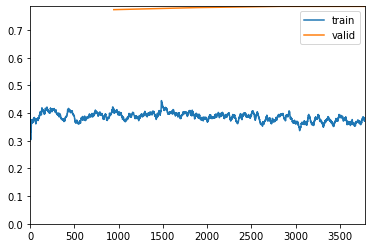

PosixPath('data/food-101/images/models/food-101-ResNet50-1e-6-3-v2.pth')

In [32]:
#change to slower learning rate
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-ResNet50-ResNet50-1e-6-3-v2', return_path=True)

### Training on image size: 512x512

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


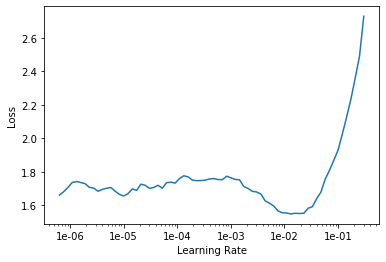

In [33]:
#use above trained model weights to train on 512X512 images
bs_512 = int(bs/2)
train_model_data = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(random_tfms, size=512)\
                            .databunch(bs=bs_512)\
                            .normalize(imagenet_stats))

learn = cnn_learner(train_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)
learn.load('food-101-ResNet50-1e-6-3-v2')

learn.lr_find()
learn.recorder.plot()

### Unfreeze 

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.995314,0.619504,0.832211,0.960000,26:13
1,1.269376,1.031435,0.723366,0.916700,26:09
2,1.219233,0.946131,0.750561,0.924488,26:09
3,1.113135,0.794579,0.792475,0.941188,26:08
4,0.840172,0.752973,0.802970,0.948251,26:09
5,0.642550,0.622935,0.834455,0.958746,26:07
6,0.480747,0.573197,0.852013,0.963366,26:08
7,0.362903,0.566079,0.855182,0.964158,26:09


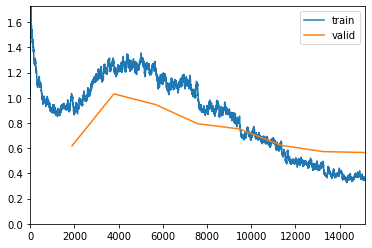

PosixPath('data/food-101/images/models/food-101-ResNet50-1e-7-2-v2-512.pth')

In [34]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-2))
learn.save('food-101-ResNet50-1e-7-2-v2-512', return_path=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.346606,0.579000,0.855446,0.964092,26:09
1,0.363528,0.572248,0.857426,0.964224,26:08
2,0.350297,0.572054,0.857624,0.965149,26:09
3,0.306874,0.567967,0.858944,0.964818,26:08


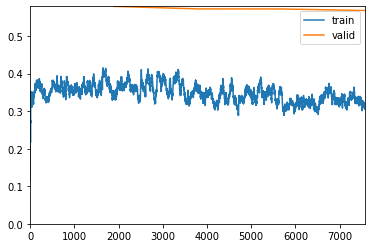

PosixPath('data/food-101/images/models/food-101-ResNet50-1e-8-3-v2-512.pth')

In [35]:
learn.fit_one_cycle(4, max_lr=slice(1e-8, 1e-3))
learn.save('food-101-ResNet50-1e-8-3-v2-512', return_path=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.325219,0.567525,0.857030,0.965545,26:08
1,0.307154,0.564441,0.859472,0.965611,26:10
2,0.283668,0.565843,0.858350,0.965545,26:08
3,0.321266,0.562885,0.858482,0.966007,26:09


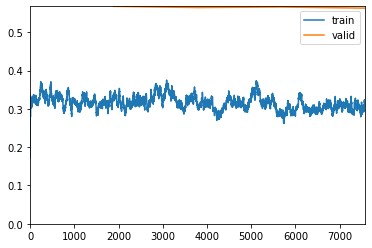

PosixPath('data/food-101/images/models/food-101-ResNet50-1e-57-55-v2-512.pth')

In [36]:
learn.fit_one_cycle(4, max_lr=slice(5e-7,5e-5))
learn.save('food-101-ResNet50-1e-57-55-v2-512', return_path=True)

### Evaluation and Test

- Two ways of evaluation will be performed
    - Without TTA 
    - with TTA
    

In [34]:
#without TTA
test_model_data = (ImageList.from_df(df=test_df,path=path_images, cols=1)\
                            .split_none()\
                            .label_from_df(cols=0)\
                            .transform(random_tfms,size=512)\
                            .databunch(bs=bs_512)\
                            .normalize(imagenet_stats))

learn = cnn_learner(test_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)

learn.load('food-101-ResNet50-1e-57-55-v2-512')

Learner(data=ImageDataBunch;

Train: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: data/food-101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fa

In [35]:
#without TTA evaluation
learn.validate(test_model_data.train_dl)

[0.43441716, tensor(0.8836), tensor(0.9776)]

### Test Time Augmentation Evaluation(TTA)

- Applies Test Time Augmentation to learn on the dataset ds_type. We take the average of our regular predictions (with a weight beta) with the average of predictions obtained through augmented versions of the training set (with a weight 1-beta). The transforms decided for the training set are applied with a few changes scale controls the scale for zoom (which isn't random), the cropping isn't random but we make sure to get the four corners of the image. Flipping isn't random but applied once on each of those corner images (so that makes 8 augmented versions total).

- `beta=0.4, scale=1.35` will applied in TTA prediction

In [36]:
#Model: food-101-ResNet50-1e-57-55-v2-512
y_preds_TTA, y_TTA = learn.TTA(ds_type= test_model_data,beta=0.4, scale=1.35)

top_1_accuracy_TTA = accuracy(y_preds_TTA, y_TTA)
top_5_accuracy_TTA = top_k_accuracy(y_preds_TTA, y_TTA, k=5)

print('TTA: top_1_accuracy: ',top_1_accuracy_TTA )
print('TTA: top_5_accuracy: ',top_5_accuracy_TTA )

TTA: top_1_accuracy:  tensor(0.8963)
TTA: top_5_accuracy:  tensor(0.9804)


### 6. Result Analysis

- Apply ClassificationInterpretation Interpretation methods for analyzing the results
`most_confused` method will give us the sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences.
        

In [39]:

interp = ClassificationInterpretation.from_learner(learn, ds_type= test_model_data)



In [41]:
interp.most_confused(min_val=5)

[('filet_mignon', 'steak', 39),
 ('steak', 'filet_mignon', 37),
 ('chocolate_mousse', 'chocolate_cake', 24),
 ('pork_chop', 'steak', 24),
 ('chocolate_cake', 'chocolate_mousse', 20),
 ('apple_pie', 'bread_pudding', 19),
 ('beef_tartare', 'tuna_tartare', 18),
 ('tuna_tartare', 'beef_tartare', 18),
 ('prime_rib', 'steak', 16),
 ('dumplings', 'gyoza', 15),
 ('pork_chop', 'filet_mignon', 14),
 ('steak', 'prime_rib', 14),
 ('club_sandwich', 'grilled_cheese_sandwich', 13),
 ('ice_cream', 'frozen_yogurt', 13),
 ('steak', 'pork_chop', 13),
 ('bread_pudding', 'apple_pie', 12),
 ('pork_chop', 'grilled_salmon', 12),
 ('ravioli', 'lasagna', 12),
 ('baby_back_ribs', 'steak', 11),
 ('french_toast', 'bread_pudding', 11),
 ('onion_rings', 'fried_calamari', 11),
 ('falafel', 'crab_cakes', 10),
 ('chicken_quesadilla', 'breakfast_burrito', 9),
 ('chocolate_mousse', 'ice_cream', 9),
 ('chocolate_mousse', 'panna_cotta', 9),
 ('clam_chowder', 'lobster_bisque', 9),
 ('gyoza', 'dumplings', 9),
 ('lobster_bisq